This is image data of Natural Scenes around the world. Data contains around 25k images of size 150x150 distributed under 6 categories.
'buildings','forest','glacier','mountain','sea','street'.

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

The aim of this notebook is to fine tune different pretrained models like Resnet, InceptionV3 and VGG, compare their performance over this dataset and determine which one works best.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
directory_list = list()
for root, dirs, files in os.walk("seg_train/", topdown=False):
    for name in dirs:
        directory_list.append(os.path.join(root, name))

labels = []        
for i in range(len(directory_list)):
    labels = print(directory_list[i][10:])
labels  

buildings
forest
glacier
mountain
sea
street


Function created to generate datasets for every type of image with preprocessing by normalizing the input data

In [2]:
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def generate_dataset(path,label):
    x_train=[]
    y_train=[]
    all_images_path=glob.glob(path+'/*.jpg')
    for img_path in all_images_path :
            img=load_img(img_path, target_size=(150,150))
            img=img_to_array(img)
            img=img/255.0
            x_train.append(img)
            y_train.append(label)
    return np.array(x_train),np.array(y_train)

Prepare the training and test sets for every label.

In [3]:
trainX_buildings, trainY_buildings  = generate_dataset("seg_train/buildings/",0)
trainX_forest, trainY_forest  = generate_dataset("seg_train/forest/",1)
trainX_glacier, trainY_glacier  = generate_dataset("seg_train/glacier/",2)
trainX_mountain, trainY_mountain  = generate_dataset("seg_train/mountain/",3)
trainX_sea, trainY_sea  = generate_dataset("seg_train/sea/",4)
trainX_street, trainY_street  = generate_dataset("seg_train/street/",5)

print('train building', trainX_buildings.shape, trainY_buildings.shape) 
print('train forest', trainX_forest.shape ,trainY_forest.shape)
print('train glacier', trainX_glacier.shape,trainY_glacier.shape)
print('train mountain', trainX_mountain.shape, trainY_mountain.shape)
print('train sea',     trainX_sea.shape, trainY_sea.shape)
print('train street', trainX_street.shape ,trainY_street.shape)

train building (2191, 150, 150, 3) (2191,)
train forest (2271, 150, 150, 3) (2271,)
train glacier (2404, 150, 150, 3) (2404,)
train mountain (2512, 150, 150, 3) (2512,)
train sea (2274, 150, 150, 3) (2274,)
train street (2382, 150, 150, 3) (2382,)


In [4]:
x_train = np.concatenate((trainX_buildings,trainX_forest,trainX_glacier,trainX_mountain,trainX_sea,trainX_street),axis=0)
y_train = np.concatenate((trainY_buildings,trainY_forest,trainY_glacier,trainY_mountain,trainY_sea,trainY_street),axis=0)
print(x_train.shape)
print(y_train.shape)

(14034, 150, 150, 3)
(14034,)


In [5]:
testX_buildings, testY_buildings  = generate_dataset("seg_test/buildings/",0)
testX_forest, testY_forest  = generate_dataset("seg_test/forest/",1)
testX_glacier, testY_glacier  = generate_dataset("seg_test/glacier/",2)
testX_mountain, testY_mountain  = generate_dataset("seg_test/mountain/",3)
testX_sea, testY_sea  = generate_dataset("seg_test/sea/",4)
testX_street, testY_street  = generate_dataset("seg_test/street/",5)

In [6]:
x_test = np.concatenate((testX_buildings,testX_forest,testX_glacier,testX_mountain,testX_sea,testX_street),axis=0)
y_test = np.concatenate((testY_buildings,testY_forest,testY_glacier,testY_mountain,testY_sea,testY_street),axis=0)

In [7]:
print(x_test.shape)
print(y_test.shape)

(3000, 150, 150, 3)
(3000,)


Implementation of the Inception-v3 model

In [8]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False
        
pre_trained_model.summary()        

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           bat

In [9]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

history = model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

last layer output shape:  (None, 3, 3, 2048)
Train on 14034 samples, validate on 3000 samples
14034/14034 [==============================] - 1469s 105ms/sample - loss: 0.9647 - acc: 0.7046 - val_loss: 0.6610 - val_acc: 0.8140


To get a closer look, let's build a confusion matrix to see how well the model classified different classes and where mistakes were made.

In [11]:
predictions = model.predict(x_test)     
pred_labels = np.argmax(predictions, axis = 1)

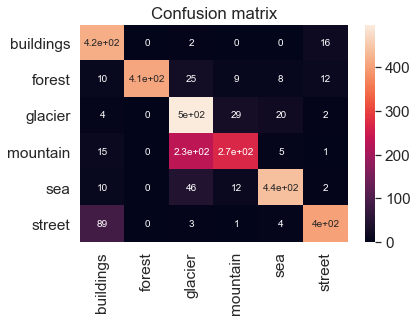

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn; sn.set(font_scale=1.4)
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
class_names = list(code.keys())
CM = confusion_matrix(y_test, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

The model mislabeled glaciers as mountains quite often. This is understandable as images of glaciers contain mountains, thereby causing confusion for the model as to what it's trying to identify.

Run the model again but this time with imagenet

In [21]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = "imagenet")

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False
        
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [22]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

history=model.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

last layer output shape:  (None, 3, 3, 2048)
Train on 14034 samples, validate on 3000 samples
14034/14034 [==============================] - 1492s 106ms/sample - loss: 0.9422 - acc: 0.7110 - val_loss: 0.9919 - val_acc: 0.7753


Let's generate a confusion matrix for this model implementation

In [23]:
predictions = model.predict(x_test)     
pred_labels = np.argmax(predictions, axis = 1)

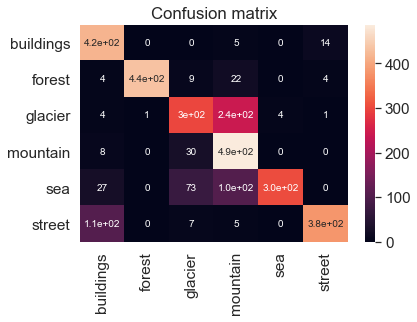

In [24]:
CM = confusion_matrix(y_test, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Using imagenet with the inception model has caused more mislabelling! Buildings were often labelled as streets, mountains as seas or glaciers as well.

Implementation of the VGG16 model with imagenet

In [25]:
from tensorflow.keras.applications import VGG16

pretrained_model = VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights = 'imagenet')

for layer in pretrained_model.layers:
     layer.trainable = False

pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [26]:
last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output= last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

model_vgg.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

last layer of vgg : output shape:  (None, 4, 4, 512)
Train on 14034 samples, validate on 3000 samples
14034/14034 [==============================] - 2694s 192ms/sample - loss: 0.4967 - acc: 0.8165 - val_loss: 0.3777 - val_acc: 0.8617


Generate the confusion matrix

In [27]:
predictions = model_vgg.predict(x_test)     
pred_labels = np.argmax(predictions, axis = 1)

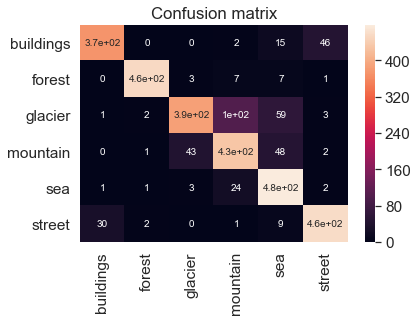

In [28]:
CM = confusion_matrix(y_test, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

While the VGG16 model does mislabel mountains as glaciers, here the number of wrongly classified glaciers is far less than that of previous models.

VGG16 with pretrained weights and without imagenet

In [29]:
file = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained_model = VGG16(input_shape = (150, 150, 3), 
                        include_top = False, 
                        weights =None)

pretrained_model.load_weights(file)

for layer in pretrained_model.layers:
     layer.trainable = False

last_layer = pretrained_model.get_layer('block5_pool')
print('last layer of vgg : output shape: ', last_layer.output_shape)
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)           

model_vgg = Model(pretrained_model.input, x) 


model_vgg.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['acc'])

model_vgg.fit(x_train,y_train,epochs=1,validation_data=(x_test,y_test))

last layer of vgg : output shape:  (None, 4, 4, 512)
Train on 14034 samples, validate on 3000 samples
14034/14034 [==============================] - 2677s 191ms/sample - loss: 0.4880 - acc: 0.8203 - val_loss: 0.3653 - val_acc: 0.8607


Generate confusion matrix

In [30]:
predictions = model_vgg.predict(x_test)     
pred_labels = np.argmax(predictions, axis = 1)

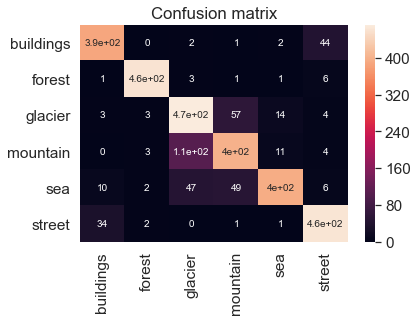

In [31]:
CM = confusion_matrix(y_test, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Curiously, here the model misidentified glaciers as mountains, in contrast to the vgg16 model with imagenet, which did the opposite. But nevertheless, the accuracies of the models are relatively similar.

The VGG16 model gave more accurate results than Inception, despite a longer run time. But this is not a concern, especially given the results in the end. VGG16 worked almost equally well with or without Imagenet, with the only difference being that one model often mistakenly labelled glaciers as mountains while the other did the opposite.

Overall, the models worked will with this dataset, but there is certainly room for improvement. The biggest issue here is undoubtetly the confusion between mountains and glaciers, as images contain both and the models cannot fully differentiate between the two. Some steps to resolve this issue would be either obtaining more images of such labels where the label in question is unmistakable, or to augment exisiting images to make it clear that there is either a mountain or a glacier. The inception model also confused streets with buildings, so if we want to choose a faster model to work with, we would need to clearly differentiate those labels before running the model.